# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

## Setup

In [2]:
sns.set()
pd.set_option('display.max_columns', None) # display all columns in a broad DataFrame

timeStart_begin = datetime.strptime("2022-04-01T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")
timeStart_close = datetime.strptime("2022-04-05T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")

In [3]:
events = pd.read_csv('events_raw.csv', delimiter=';')
sessions = pd.read_csv('sessions_raw.csv', delimiter=';')

## Preparation

### Merge and Alter the Sessions

In [4]:
events = events[["sid", "eventType", "time", "pageUrl"]]
events["eventType"] = events["eventType"].astype("category")

sessions.reset_index()
eventsTypes = []
eventsTimes = []
pageUrl = []
eventsCount = []

for index, session in sessions.iterrows():
    session_events = events[events["sid"] == session["id"]]
    eventsTypes.append([i for i in session_events["eventType"].tolist() if not pd.isnull(i)])
    eventsCount.append(len(session_events))
    
    max_time = session_events["time"].max()
    min_time = 0
    partitioned_times = []
    for session_event_time in session_events["time"].tolist():
        if not pd.isnull(session_event_time):
            if session_event_time <= min_time:
                partitioned_times.append(1.0)
            elif max_time == session_event_time:
                partitioned_times.append(10.0)
            else:
                # sparse event time occurrences in a session into 10 time segments during session's duration
                partitioned_times.append(np.ceil(session_event_time / max_time * 10))
        
    eventsTimes.append(partitioned_times)
    pageUrl.append([i.replace('\'', '').strip() for i in session_events["pageUrl"] if not pd.isnull(i)])
    
sessions["eventsTypes"] = eventsTypes
sessions["eventsTimes"] = eventsTimes
sessions["pageBaseUrl"] = pageUrl
sessions["eventsCount"] = eventsCount
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246 entries, 0 to 6245
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6246 non-null   object 
 1   uid                4740 non-null   float64
 2   timeStart          6246 non-null   object 
 3   timeClose          6246 non-null   object 
 4   duration           6246 non-null   int64  
 5   pageReferer        3589 non-null   object 
 6   browserCode        6246 non-null   object 
 7   platformCode       6246 non-null   object 
 8   countryCode        6233 non-null   object 
 9   countryCity        5729 non-null   object 
 10  deviceType         6246 non-null   object 
 11  deviceOrientation  0 non-null      float64
 12  deviceWidth        6246 non-null   int64  
 13  deviceHeight       6246 non-null   int64  
 14  pageFirst          6246 non-null   object 
 15  pageLast           6246 non-null   object 
 16  pageUrl            6246 

### Convert Session Attributes to Correct Types

In [8]:
sessions["timeStart"] = sessions["timeStart"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
sessions["timeClose"] = sessions["timeClose"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
sessions["pageReferer"] = sessions["pageReferer"].astype("category")
sessions["browserCode"] = sessions["browserCode"].astype("category")
sessions["platformCode"] = sessions["platformCode"].astype("category")
sessions["countryCode"] = sessions["countryCode"].astype("category")
sessions["countryCity"] = sessions["countryCity"].astype("category")
sessions["deviceType"] = sessions["deviceType"].astype("category")
sessions["pageFirst"] = sessions["pageFirst"].astype("category")
sessions["pageLast"] = sessions["pageLast"].astype("category")

# Feature Selection and Extraction

## Session Features

### Date Features

In [10]:
timeStart_seconds = (sessions["timeStart"] - timeStart_begin).apply(lambda x: x.total_seconds())
timeClose_seconds = (sessions["timeClose"] - timeStart_begin).apply(lambda x: x.total_seconds())
time_correlation = pd.DataFrame({"timeStart_seconds": timeStart_seconds, "timeClose_seconds": timeClose_seconds, "duration": sessions["duration"]})
reduced_timeDate = pd.DataFrame({"timeStart_seconds": timeStart_seconds})
time_correlation.corr(method='pearson')

,timeStart_seconds,timeClose_seconds,duration
timeStart_seconds,1.000000,0.987417,-0.045537
timeClose_seconds,0.987417,1.000000,-0.019923
duration,-0.045537,-0.019923,1.000000


### Categorical Features

In [16]:
browserCode_reduced = sessions["browserCode"] == "chrome" # is chrome

platformCode_reduced = ["other" if i not in ["mac","windows"] else i for i in sessions["platformCode"]]

countryCode_reduced = ["other" if i not in ["us", "br", "it", "in", "cz"] else i for i in sessions["countryCode"]]

reduced_categorical = pd.DataFrame({"isChromeBrowser": browserCode_reduced, "platform": platformCode_reduced, "country": countryCode_reduced})
reduced_categorical["platform"] = reduced_categorical["platform"].astype("category")
reduced_categorical["country"] = reduced_categorical["country"].astype("category")
print("Country Value Counts")
print(reduced_categorical["country"].value_counts())
print("Platform Value Counts")
print(reduced_categorical["platform"].value_counts())
print("Chrome Browser Value Counts")
print(reduced_categorical["isChromeBrowser"].value_counts())

Country Value Counts
other    3502
us        833
cz        652
in        552
br        367
it        340
Name: country, dtype: int64
Platform Value Counts
windows    3323
mac        2465
other       458
Name: platform, dtype: int64
Chrome Browser Value Counts
True     4916
False    1330
Name: isChromeBrowser, dtype: int64


## Reduction of Event Array Features

### Event Types

In [20]:
vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(sessions["eventsTypes"].str.join(' '))
reduced_eventsTypes = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
reduced_eventsTypes = reduced_eventsTypes.add_prefix("eventRatio_")
reduced_eventsTypes = reduced_eventsTypes.T.apply(lambda x: [i/sum(x) for i in x]).T
reduced_eventsTypes["hasErrorEvent"] = reduced_eventsTypes["eventRatio_error"].astype("bool")
reduced_eventsTypes.drop(["eventRatio_rage_click", "eventRatio_error"], axis=1, inplace=True)

### Page URL

In [19]:
prepared_pageUrl = sessions["pageBaseUrl"]
prepared_pageUrl = prepared_pageUrl.apply(lambda x: [i.split("?")[0] for i in x])
prepared_pageUrl = prepared_pageUrl.apply(lambda x: [i.split("/")[0] for i in x]) # keep only the base url for now - investigate unifying all IDS in url
vectorizer = CountVectorizer(token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
matrix = vectorizer.fit(prepared_pageUrl.str.join(' '))
reduced_pageUrl = pd.DataFrame(matrix.transform(prepared_pageUrl.str.join(' ')).toarray(), columns=vectorizer.get_feature_names_out())
reduced_pageUrl = reduced_pageUrl.add_prefix("eventsUrlBaseRatio_")
reduced_pageUrl = reduced_pageUrl.T.apply(lambda x: [i/sum(x) for i in x]).T
reduced_pageUrl["eventsUrlBaseRatio_other"] = 1 - reduced_pageUrl["eventsUrlBaseRatio_app.smartlook.com"]
reduced_pageUrl = reduced_pageUrl[["eventsUrlBaseRatio_app.smartlook.com"]]

### Event Times

In [22]:
prepared_eventsTimes = sessions["eventsTimes"].apply(lambda x: list(map(str, x)))
vectorizer = CountVectorizer(token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
matrix = vectorizer.fit(prepared_eventsTimes.str.join(' '))
reduced_eventsTimes = pd.DataFrame(matrix.transform(prepared_eventsTimes.str.join(' ')).toarray(), columns=map(lambda x: str(x) + "%", (np.arange(1, 11) * 10)))
reduced_eventsTimes = reduced_eventsTimes.add_prefix("eventsTimeRatio_")
reduced_eventsTimes = reduced_eventsTimes.T.apply(lambda x: [i/sum(x) for i in x]).T
reduced_eventsTimes["eventsTimeRatio_other"] = 1 - reduced_eventsTimes["eventsTimeRatio_10%"] - reduced_eventsTimes["eventsTimeRatio_20%"]
reduced_eventsTimes = reduced_eventsTimes[["eventsTimeRatio_10%", "eventsTimeRatio_20%", "eventsTimeRatio_other"]]

## Construct Dataset from Transformed Features

In [23]:
sessions_strip = sessions[["id", "duration", "deviceWidth", "deviceHeight", "eventsCount", ]]
sessions_reduced = pd.concat([sessions_strip, reduced_timeDate, reduced_categorical, reduced_eventsTypes, reduced_eventsTimes, reduced_pageUrl], axis=1)
sessions_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6246 entries, 0 to 6245
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   id                                    6246 non-null   object  
 1   duration                              6246 non-null   int64   
 2   deviceWidth                           6246 non-null   int64   
 3   deviceHeight                          6246 non-null   int64   
 4   eventsCount                           6246 non-null   int64   
 5   timeStart_seconds                     6246 non-null   float64 
 6   isChromeBrowser                       6246 non-null   bool    
 7   platform                              6246 non-null   category
 8   country                               6246 non-null   category
 9   eventRatio_click                      6246 non-null   float64 
 10  eventRatio_custom                     6246 non-null   float64 
 11  even

## Normalization, Standardization and Scaling

In [25]:
sessions_scaled = sessions_reduced.drop(["id"], axis=1)
encoder = OneHotEncoder()
minmaxscaler = MinMaxScaler()
robustscaler = RobustScaler(quantile_range=(3, 97))

# categorical
sessions_scaled = sessions_scaled.join(pd.DataFrame(encoder.fit_transform(sessions_scaled[["platform"]]).toarray(), columns=encoder.get_feature_names_out()))
sessions_scaled = sessions_scaled.join(pd.DataFrame(encoder.fit_transform(sessions_scaled[["country"]]).toarray(), columns=encoder.get_feature_names_out()))

# numerical
sessions_scaled["deviceWidth"] = minmaxscaler.fit_transform(sessions_scaled[["deviceWidth"]])
sessions_scaled["deviceHeight"] = minmaxscaler.fit_transform(sessions_scaled[["deviceHeight"]])
sessions_scaled["timeStart_seconds"] = minmaxscaler.fit_transform(sessions_scaled[["timeStart_seconds"]])
# robust because of outliers
sessions_scaled["duration"] = robustscaler.fit_transform(sessions_scaled[["duration"]])
sessions_scaled["eventsCount"] = robustscaler.fit_transform(sessions_scaled[["eventsCount"]]) 

sessions_scaled.drop(["country", "platform"], axis=1, inplace=True)
sessions_scaled.describe()

,duration,deviceWidth,deviceHeight,eventsCount,timeStart_seconds,eventRatio_click,eventRatio_custom,eventRatio_focus,eventRatio_url,eventsTimeRatio_10%,eventsTimeRatio_20%,eventsTimeRatio_other,eventsUrlBaseRatio_app.smartlook.com,platform_mac,platform_other,platform_windows,country_br,country_cz,country_in,country_it,country_other,country_us
count,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6.246000e+03,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000,6246.000000
mean,0.111703,0.289591,0.242346,0.119494,0.524801,0.263143,0.127895,0.118826,0.480700,0.318942,0.312453,3.686052e-01,0.771076,0.394653,0.073327,0.532020,0.058758,0.104387,0.088377,0.054435,0.560679,0.133365
std,0.330227,0.116458,0.101943,0.377988,0.216593,0.203249,0.162816,0.136255,0.288846,0.231980,0.309289,2.626805e-01,0.414342,0.488815,0.260693,0.499014,0.235189,0.305786,0.283864,0.226892,0.496344,0.339996
min,-0.047840,0.000000,0.000000,-0.061626,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.001126,-5.551115e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.038827,0.233333,0.170171,-0.052145,0.368008,0.000000,0.000000,0.000000,0.276596,0.142857,0.083333,9.090909e-02,0.946488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.283333,0.261125,0.000000,0.525831,0.285714,0.078169,0.070809,0.363636,0.333333,0.181818,4.000000e-01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.113707,0.333333,0.275795,0.123252,0.683229,0.392857,0.200000,0.216216,0.582661,0.500000,0.500000,5.806452e-01,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,10.334188,1.000000,1.000000,7.001659,1.000000,0.970588,0.833333,0.833333,1.000000,0.986842,1.000000,9.545455e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Drop Highly Correlated Features

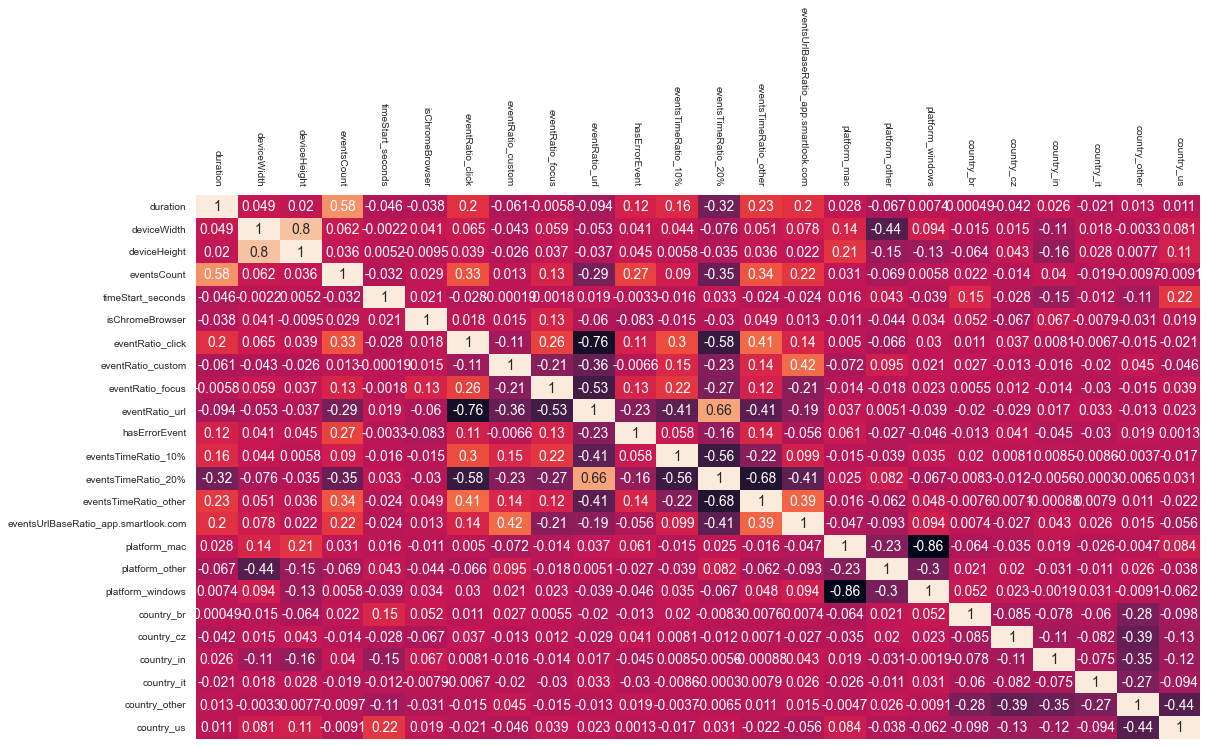

In [26]:
sns.set(rc = {'figure.figsize':(18,10)}, font_scale=1.15)
ax = sns.heatmap(sessions_scaled.corr(), annot=True, cbar=False)
pyplot.tick_params(which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 270)
pyplot.show()

In [27]:
sessions_scaled.drop(["platform_windows"], inplace=True, axis=1)

## Visualization and Dimensionality Reduction

### Cumulative Variance Explained Decrease

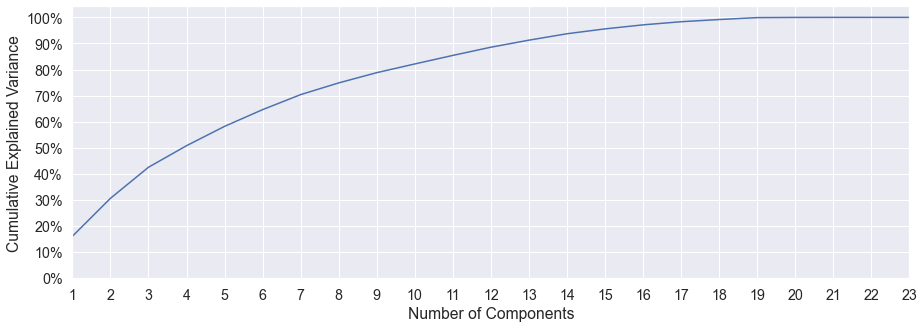

In [31]:
sns.set(rc = {'figure.figsize':(15,5)}, font_scale=1.3)
pca = PCA().fit(sessions_scaled)
ax = sns.lineplot(y=np.cumsum(pca.explained_variance_ratio_), x=np.arange(1, len(pca.explained_variance_ratio_)+1))
ax.set(xticks=np.arange(1, len(pca.explained_variance_ratio_)+1), xlim=(1, len(pca.explained_variance_ratio_)), yticks=np.arange(0, 1.1, 0.1), yticklabels=['{}%'.format(x) for x in np.arange(0, 110, 10)])
ax.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance')
pyplot.show()

### Cumulative Variance Explained by Two Components per Feature

In [28]:
pca_2 = PCA(n_components=2)
pca_2_result = pd.DataFrame(pca_2.fit_transform(sessions_scaled))
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=sessions_scaled.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca.T.sort_values(by=['PC_1', 'PC_2'], ascending=False).apply(lambda x: np.round(x*100, 2)))

Explained variation per principal component: [0.16084665 0.14547845]
Cumulative variance explained by 2 principal components: 30.63%


                                        PC_1   PC_2
eventsCount                           45.25   8.32
eventsUrlBaseRatio_app.smartlook.com  44.52   3.50
eventsTimeRatio_20%                   43.50   5.79
duration                              32.37   4.51
eventRatio_url                        31.98   4.01
eventsTimeRatio_other                 29.94   3.72
eventRatio_click                      20.42   3.77
eventsTimeRatio_10%                   13.57   2.06
hasErrorEvent                         13.56   1.38
country_other                         11.34  88.08
eventRatio_custom                      7.97   0.86
country_us                             6.97  32.36
platform_other                         5.15   3.61
eventRatio_focus                       4.19   1.44
isChromeBrowser                        3.29   5.42
platform_mac                           2.83   7.

### Visualization of Sessions in 1D Space

Explained variation per principal component: [0.16084665]
Cumulative variance explained by 1 principal component: 16.08%


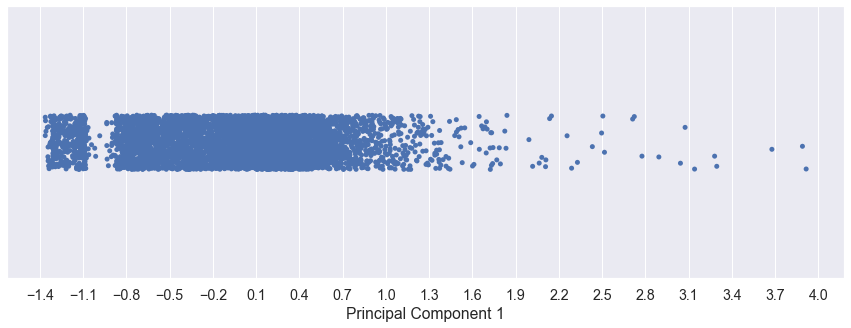

In [30]:
sns.set(rc = {'figure.figsize':(15,5)}, font_scale=1.3)
pca_1 = PCA(n_components=1)
pca_1_result = pd.DataFrame(pca_1.fit_transform(sessions_scaled))
print('Explained variation per principal component: {}'.format(pca_1.explained_variance_ratio_))
print('Cumulative variance explained by 1 principal component: {:.2%}'.format(np.sum(pca_1.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_1.components_), columns=sessions_scaled.columns, index=['PC_1'])
ax = sns.stripplot(x=0, data=pca_1_result, hue=sns.color_palette("cubehelix", as_cmap=True), dodge=False, alpha=1)
ax.set(xticks=np.arange(-1.4, 4.1, 0.3))
ax.set(xlabel='Principal Component 1')
pyplot.show()

### Visualization of Sessions in 2D Space

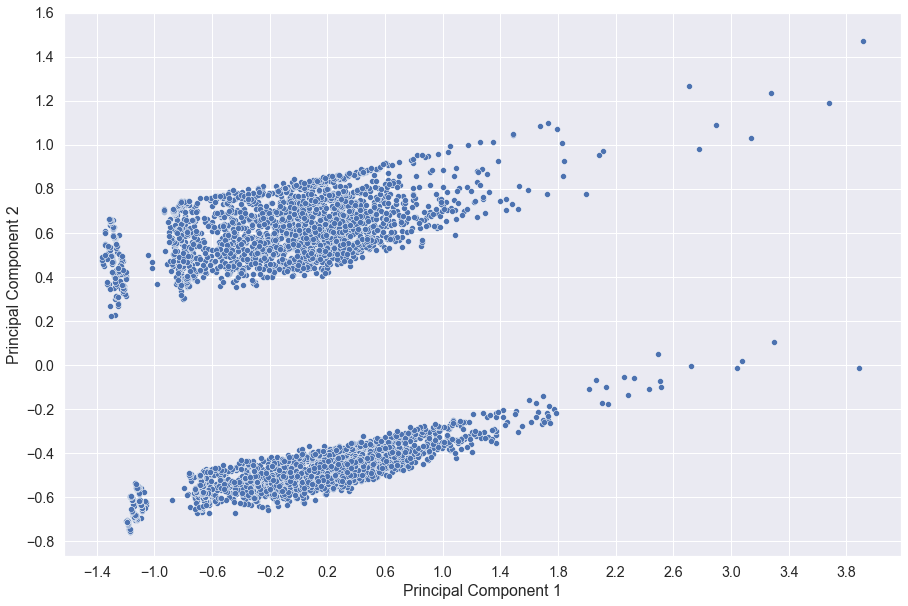

In [29]:
sns.set(rc = {'figure.figsize':(15,10)}, font_scale=1.3)
sns.color_palette("cubehelix", as_cmap=True)
ax = sns.scatterplot(x=0, y=1, data=pca_2_result)
ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2')
ax.set(xticks=np.arange(-1.4, 4.1, 0.4), yticks=np.arange(-0.8, 1.6, 0.2))
pyplot.show()

In [32]:
pca_3d = PCA(n_components=3)
sessions_pca_3d = pd.DataFrame(pca_3d.fit_transform(sessions_scaled), columns=["PC1", "PC2", "PC3"])

print('Explained variation per principal component: {}'.format(pca_3d.explained_variance_ratio_))
print('Cumulative variance explained by 3 principal components: {:.2%}'.format(np.sum(pca_3d.explained_variance_ratio_)))

Explained variation per principal component: [0.16084664 0.14547843 0.11910736]
Cumulative variance explained by 3 principal components: 42.54%


In [33]:
%matplotlib widget

### Visualization of Sessions in 3D Space

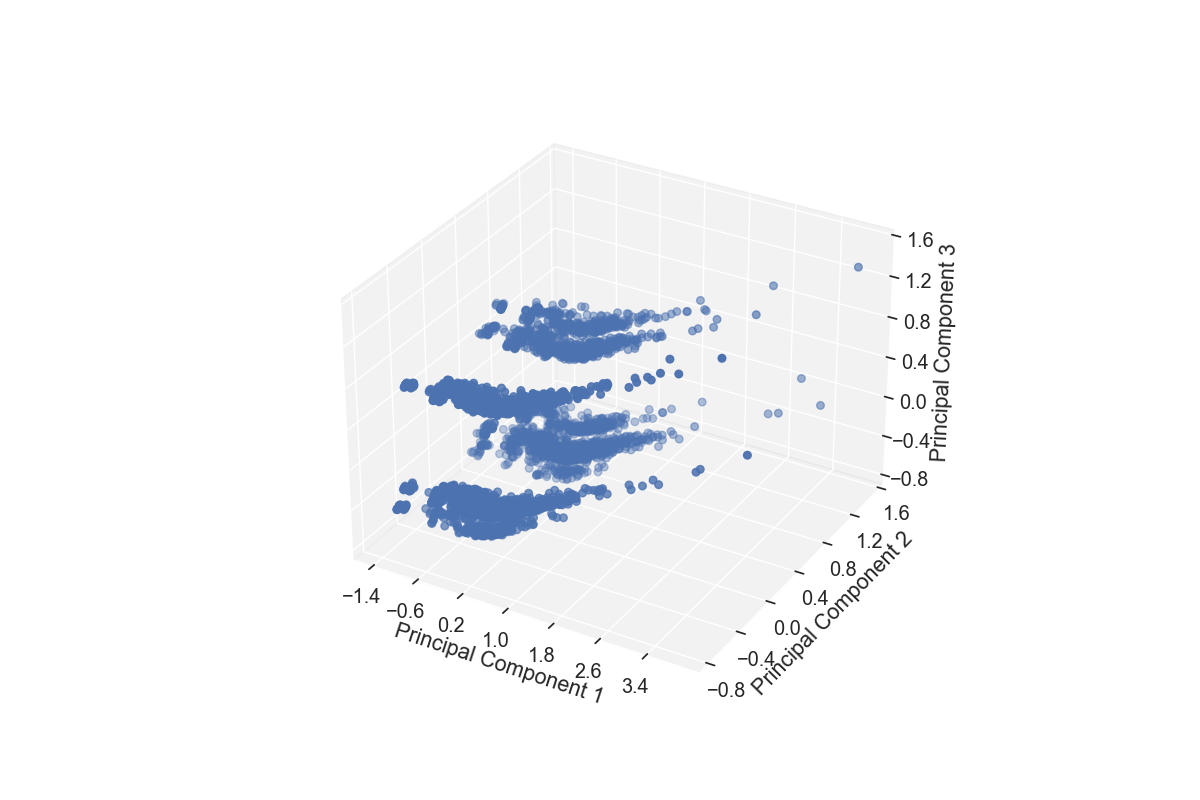

In [34]:
fig = pyplot.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')
pyplot.rcParams['grid.color'] = 'darkgray'
ax.w_xaxis.set_pane_color((0.9, 0.9, 0.9, 0.5))
ax.w_yaxis.set_pane_color((0.9, 0.9, 0.9, 0.5))
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 0.5))

sc = ax.scatter(sessions_pca_3d.PC1, sessions_pca_3d.PC2, sessions_pca_3d.PC3, cmap=sns.color_palette("cubehelix", as_cmap=True), s=30, marker='o')
ax.set(xticks=np.arange(-1.4, 4.1, 0.8), yticks=np.arange(-0.8, 1.6, 0.4), zticks=np.arange(-0.8, 1.6, 0.4), xlabel='Principal Component 1', ylabel='Principal Component 2', zlabel='Principal Component 3')
pyplot.show()

# Save Preprocessed Dataset

In [35]:
sessions_scaled["id"] = sessions_reduced["id"]
sessions_scaled.to_csv("sessions_preprocessed.csv", sep=';', index=False)